<a href="https://colab.research.google.com/github/Rubeennn/Dog_Cat_dataset/blob/main/Cat_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
! kaggle datasets download -d unmoved/30k-cats-and-dogs-150x150-greyscale

Dataset URL: https://www.kaggle.com/datasets/unmoved/30k-cats-and-dogs-150x150-greyscale
License(s): CC0-1.0
 97% 129M/133M [00:02<00:00, 71.7MB/s]
100% 133M/133M [00:02<00:00, 61.8MB/s]


In [6]:
from pathlib import Path

data_path = Path('data')

data_path.mkdir(exist_ok=True, parents=True)


In [7]:
import zipfile

with zipfile.ZipFile('30k-cats-and-dogs-150x150-greyscale.zip', 'r') as z:
    z.extractall(data_path)

In [8]:
cat_path = data_path / 'Animal Images' / 'cats'
cat_path
dog_path = data_path / 'Animal Images' / 'dogs'

### Importing the necessary packages

In [9]:
import numpy as np
from PIL import Image
import pandas as pd
import torch
from torch import nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os

Shape of the image is: (150, 150)


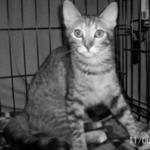

In [40]:
# Visualizing one image
cat_image_names = os.listdir(cat_path)
first_cat_image_path = cat_path / cat_image_names[0]
img = Image.open(fp=first_cat_image_path)
print(f'Shape of the image is: {np.asarray(img).shape}')
img

2. Now we define the path to the image directory
and then gaining the dataset with **ImageFolder**.

In [46]:
data_path

PosixPath('data')

In [54]:
dataset = ImageFolder(

    root = data_path / 'Animal Images',
    transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(124,124)), # Maybe need to make it smaller
    transforms.ToTensor()
    ])
)

In [55]:
label_to_find = 1
found_images = False

for img_idx, (image, label) in enumerate(dataset):
    if label == label_to_find:
        found_images = True
        print(f"Found an image with label {label_to_find} at index {img_idx}")
        # Optionally, print or visualize the image
        # print(image)  # This is a tensor, you might want to convert it back to a PIL image for visualization
        break

if not found_images:
    print(f"No images found with label {label_to_find}")

Found an image with label 1 at index 15060


In [56]:
# Splitting the dataset into train, test and validation datasets.

torch.manual_seed(42)
from torch.utils.data import random_split, DataLoader

train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.15)

val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset,
                                                        [train_size,
                                                         test_size,
                                                         val_size]
                                                       )


1. Splitting data into batches using the *DataLoader*.

In [57]:

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count()
                             )

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=os.cpu_count()
                        )

val_loader = DataLoader(dataset=val_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False,
                       num_workers=os.cpu_count())

## 3. Bulding the model

In [58]:
class DogCat(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape=1):
        super().__init__()

        self.block1 = nn.Sequential(nn.BatchNorm2d(num_features=1),
                                   nn.Conv2d(in_channels=1,
                                             out_channels=3,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=1
                                            ),
                                    nn.BatchNorm2d(num_features=3),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=3,
                                              out_channels=6,
                                              kernel_size=(3,3),
                                              stride=1,
                                              padding=1
                                    ),
                                    nn.BatchNorm2d(num_features=6),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=(3,3)),
                                    nn.Dropout2d(p=0.2)
                                   )

        self.block2 = nn.Sequential(nn.BatchNorm2d(num_features=6),
                                   nn.Conv2d(in_channels=6,
                                             out_channels=9,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=1
                                            ),
                                    nn.BatchNorm2d(num_features=9),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=9,
                                              out_channels=12,
                                              kernel_size=(3,3),
                                              stride=1,
                                              padding=1
                                    ),
                                    nn.MaxPool2d(kernel_size=(3,3)),
                                    nn.BatchNorm2d(num_features=12),
                                    nn.ReLU(),
                                    nn.Dropout2d(p=0.2))

        self.classifier = nn.Sequential(nn.Flatten(),
                                       nn.Linear(in_features=2028,
                                                out_features=124),
                                        nn.Linear(in_features=124,
                                                 out_features=output_shape)
                                       )
    def forward(self, X):
#         print(X.shape)
        X = self.block1(X)
#         print(X.shape)
        X = self.block2(X)
#         print(X.shape)
        X = self.classifier(X)
#         print(X.shape)
        return X

In [59]:
model = DogCat(input_shape=124,
              hidden_shape=10)

In [60]:
# Assuming train_dataloader is your DataLoader
for batch_idx, (X_batch, y_batch) in enumerate(train_dataloader):
    # Iterate through the batch
    for X, y in zip(X_batch, y_batch):
        # Check if y == 1
        if y == 1:
            # Print or store the element
            print(f"Found element where y == 1:")
            print(f"X: {X}")
            print(f"y: {y}")
            # Exit the loop once the first occurrence is found
            break
    else:
        continue  # Continue to the next batch if not found
    break  # Exit the outer loop once the first occurrence is found


Found element where y == 1:
X: tensor([[[0.0549, 0.0627, 0.0824,  ..., 0.7529, 0.8706, 0.8745],
         [0.0588, 0.0588, 0.0706,  ..., 0.5137, 0.7294, 0.7961],
         [0.0745, 0.0706, 0.0784,  ..., 0.3686, 0.5020, 0.6275],
         ...,
         [0.5961, 0.5922, 0.6118,  ..., 0.6353, 0.6275, 0.6275],
         [0.5765, 0.5765, 0.6000,  ..., 0.6235, 0.6157, 0.6157],
         [0.5608, 0.5647, 0.5961,  ..., 0.6118, 0.6039, 0.6039]]])
y: 1


In [61]:
optimizer = torch.optim.Adam(params=model.parameters(),
                       lr=0.001)

loss = nn.BCEWithLogitsLoss()

In [62]:
from tqdm.auto import tqdm

In [63]:
len(train_dataloader)

329

In [64]:
import time

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [66]:
model.to(device)

DogCat(
  (block1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kerne

In [67]:
epochs = 5
start_time = time.time()
for epoch in tqdm(range(epochs)):
    train_total_loss = 0
    train_total_acc = 0
    total_val_loss = 0
    total_val_acc = 0
    for batch , (X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()

        y_train_pred_logits = model(X)
        y = y.unsqueeze(dim=-1).to(torch.float)

        y_pred_probas = torch.sigmoid(y_train_pred_logits)

        y_pred = torch.argmax(y_pred_probas, axis=1)

        # print(y)
        train_loss = loss(y_train_pred_logits, y)
        # print(y_train_pred_logits, y)
        # print(f'Train loss: {train_loss}')
        train_total_loss += train_loss.item()

        train_total_acc += (torch.sum(y_pred == y.squeeze()).item() / len(y)) * 100


        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

    with torch.inference_mode():
        model.eval()
        for (X_val, y_val) in val_loader:

            X_val, y_val = X_val.to(device), y_val.to(device)

            y_val_pred_logits = model(X_val)
            y_val_pred = torch.argmax(torch.sigmoid(y_val_pred_logits), axis=1)

            y_val = y_val.unsqueeze(dim=-1).to(torch.float)

            val_loss = loss(y_val_pred_logits, y_val)
            # print(f'Validation loss: {val_loss}')
            total_val_loss += val_loss.item()
            total_val_acc += (torch.sum(y_val_pred == y_val.squeeze()).item() / len(y_val)) * 100

    print(f'Train loss: {train_total_loss / len(train_dataloader)},train_acc: {total_val_acc / len(train_dataloader)}, Val loss: {total_val_loss / len(val_loader)}, val_acc: {total_val_acc / len(val_loader)}')


end_time = time.time()
print(f'time spent: {end_time - start_time}')







  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.643065992278531,train_acc: 10.795022796352583, Val loss: 0.5749237243558319, val_acc: 50.02200704225352
Train loss: 0.5874774761294159,train_acc: 10.795022796352583, Val loss: 0.5525799775627297, val_acc: 50.02200704225352
Train loss: 0.5634398330852254,train_acc: 10.795022796352583, Val loss: 0.5262515746371846, val_acc: 50.02200704225352
Train loss: 0.545171690748093,train_acc: 10.795022796352583, Val loss: 0.5213173569088251, val_acc: 50.02200704225352
Train loss: 0.5309583647997546,train_acc: 10.795022796352583, Val loss: 0.5121459835012194, val_acc: 50.02200704225352
time spent: 92.62990069389343


In [ ]:
a = torch.Tensor([1,1,1,1])
b = torch.Tensor([1,1,0,1])
print((sum(a == b) /len(a)) * 100)


tensor(75.)


In [ ]:
a.shape, a.squeeze().shape

(torch.Size([1, 4]), torch.Size([4]))

In [ ]:
{1,2,3} * 5

TypeError: unsupported operand type(s) for *: 'set' and 'int'